# Probes
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/VirtualBrainLab/urchin-examples/blob/main/basics/probes.ipynb)

## Install Urchin

Urchin is a Python package stored on PyPI, the following code needs to be run the first time you use Urchin in a Python environment. 

Urchin's full documentation can be found [on our website](https://virtualbrainlab.org/urchin/installation_and_use.html).

In [ ]:
#Installing urchin
!pip install oursin -U

# Pandas also required for this tutorial
!pip install pandas

## Setup Urchin and open the renderer webpage 

By default Urchin opens the 3D renderer in a webpage. Make sure pop-ups are enabled, or the page won't open properly. You can also open the renderer site yourself by replacing [ID here] with the ID that is output by the call to `.setup()` at https://data.virtualbrainlab.org/Urchin/?ID=[ID here]

Note that Urchin communicates to the renderer webpage through an internet connection, we don't currently support offline use (we hope to add support in the future).

In [1]:
#Importing necessary libraries:
import oursin as urchin
import pandas as pd
urchin.setup()

(URN) connected to server
Login sent with ID: 0d284442, copy this ID into the renderer to connect.


## Download data
For this tutorial, let's explore the dataset from [Steinmetz et al.  2019](https://www.nature.com/articles/s41586-019-1787-x). We'll get the position of all the insertions and then display them within a 3D mesh of the brain, recreating figure 1h.

![steinmetz_2019_1h](./data/steinmetz_2019_1h.png)

In [2]:
# Define a quick convenience function for loading data
def get_data(url):
    data = url.replace("/edit#gid=", "/export?format=csv&gid=")
    df = pd.read_csv(data)
    return df

The angles in the original dataset also need to be rotated to match the conventions in Urchin.

In [3]:
probe_data = get_data('https://docs.google.com/spreadsheets/d/1T-RG3d_MIBXZKmrGmLnsU-O7GmwY09Z0FY6yqbYyZXI/edit#gid=1457359713')
probe_data["theta"] = 90 - probe_data["theta"]
probe_data["phi"] = 270 - probe_data["phi"] 

### Data overview
ML, AP, and DV, refer to the coordinates of the tip of the probe along the medial-lateral, anterior-posterior, and dorsal-ventral axes, within the CCF coordinate space. The phi and theta angles correspond to yaw (azimuth) and pitch (elevation) in Urchin.

In [4]:
probe_data.head()

,session,ml,ap,dv,phi,theta,color
0,1,4990.354988,4463.941496,4907.275550,367.040203,98.599869,#EE204D
1,1,3170.782413,8732.329581,4900.724878,217.514548,105.903551,#EE204D
2,2,2562.465091,7686.413000,4851.170969,215.946819,107.513591,#EE204D
3,2,3707.683990,9400.993675,4086.404032,381.000255,98.227467,#EE204D
4,3,3312.941208,8478.681979,4061.106429,387.548431,104.063265,#EE204D


## Setup the scene

Because probe coordinates relative to the active Atlas, we do need to load the CCF before we can put any probes in the scene. We also need the Atlas to render the brain.

In [5]:
urchin.ccf25.load()

We'll load the outer "grey matter" shell of the brain:

In [8]:
urchin.ccf25.grey.set_visibility(True)
urchin.ccf25.grey.set_material('transparent-unlit')
urchin.ccf25.grey.set_color('#000000')
urchin.ccf25.grey.set_alpha(0.1)

Throughout this tutorial, we'll use the screenshot function on the main camera to see what effect we had on the scene. Note that because taking screenshots requires waiting for data to come back, you need to use the Python `await` keyword and it's good practice to put a screenshot in its own code block. If you're running in a script, you should put a `time.sleep(0.1)` call before each screenshot.

(Camera receive) Camera CameraMain received an image
(Camera receive) CameraMain complete


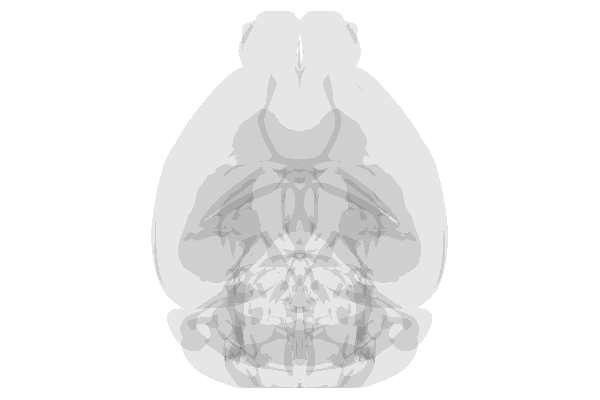

In [11]:
urchin.camera.main.set_zoom(7)
await urchin.camera.main.screenshot(size=[600,400])

## Setting up the probes

Let's create a `Probe` object for each row in the data dictionary

In [10]:
probes = urchin.probes.create(len(probe_data))

By default the probes are white, which isn't very convenient for seeing what's happening. Let's set the colors of the probes according to the values in the dataframe. These roughly match what's in the paper (as you'll see below)

In [13]:
urchin.probes.set_colors(probes,list(probe_data["color"].values))

(Camera receive) Camera CameraMain received an image
(Camera receive) CameraMain complete


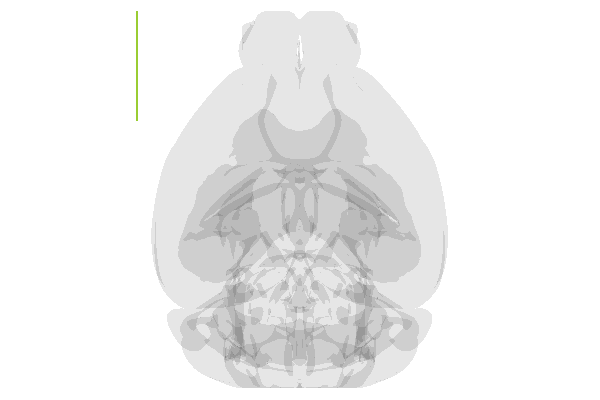

In [14]:
await urchin.camera.main.screenshot(size=[600,400])

To set the position of each probe, we need to pass a list or tuple of position values (AP, ML, DV). Urchin expects these input values to be in um.

To make this easier to see, we'll loop through the dataframe and build up the position list, then send it to Urchin. If you've looked at any other tutorials you'll know that Urchin has both singular functions `Probe.set_position([ap, ml, dv])` and plural functions `urchin.probes.set_positions(probes_list, positions_list)`. There's less communication overhead when using the plural functions, so we tend to prefer them.

In [15]:
positions_list = []

for i, row in probe_data.iterrows():
    position = [row['ap'], row['ml'], row['dv']]
    positions_list.append(position)

urchin.probes.set_positions(probes, positions_list) #setting the positions within the renderer

(Camera receive) Camera CameraMain received an image
(Camera receive) CameraMain complete


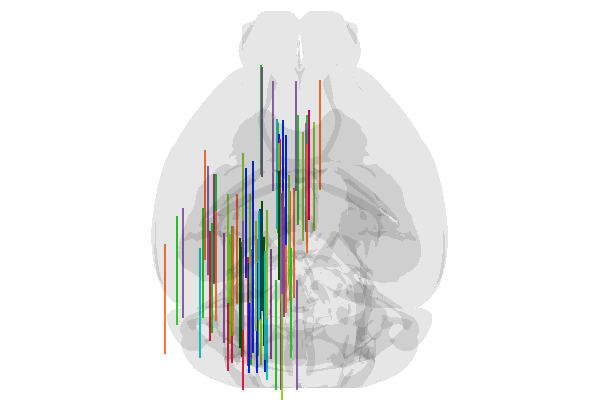

In [16]:
await urchin.camera.main.screenshot(size=[600,400])

Okay! Great! Execpt that all the probes are pointing forwards. We set the convention in Urchin that a probe with (yaw, pitch, roll) angles of (0,0,0) is pointing anterior and flat on the AP/ML plane. For most rigs, this is equivalent to laying the probe on the rig surface, pointing forward, with the electrode surface facing up. This convention is shared with Pinpoint.

We'll use a similar block of code to set the angles.

In [17]:
angles_list = []

for i, row in probe_data.iterrows():
    angle = [row['phi'], row['theta'], 0] # roll is set to 0
    angles_list.append(angle)

urchin.probes.set_angles(probes, angles_list) #setting the positions within the renderer

(Camera receive) Camera CameraMain received an image
(Camera receive) CameraMain complete


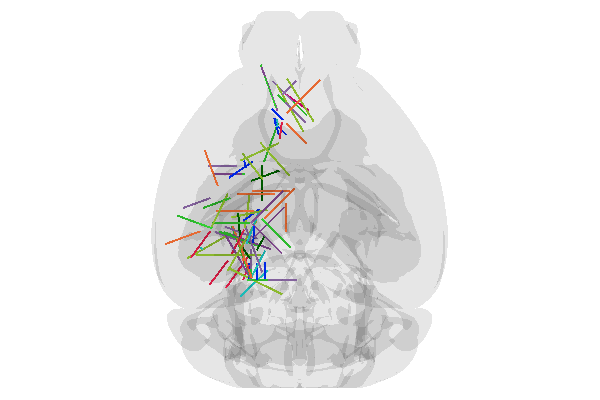

In [18]:
await urchin.camera.main.screenshot(size=[600,400])

Pretty good! But does it match the figures in the paper? Let's regenerate Figure 1h using the multi-camera feature. Then make our own version of the same plot.

![steinmetz_2019_1h](./data/steinmetz_2019_1h.png)

In [20]:
s_cam = urchin.camera.Camera()
h_cam = urchin.camera.Camera()
c_cam = urchin.camera.Camera()

In [45]:
s_cam.set_rotation([0,-90,90])
s_cam.set_zoom(7)

h_cam.set_rotation([0,0,90])
h_cam.set_zoom(7)

c_cam.set_rotation([-90,0,0])
c_cam.set_zoom(7)

urchin.camera.main.set_rotation('angled')
urchin.camera.main.set_mode('perspective')
urchin.camera.main.set_zoom(60)

In [46]:
s_png = await s_cam.screenshot(size=[300,300])
h_png = await h_cam.screenshot(size=[300,300])
c_png = await c_cam.screenshot(size=[300,300])

angled_png = await urchin.camera.main.screenshot(size=[600,900])

(Camera receive) Camera Camera1 received an image
(Camera receive) Camera1 complete
(Camera receive) Camera Camera2 received an image
(Camera receive) Camera2 complete
(Camera receive) Camera Camera3 received an image
(Camera receive) Camera3 complete
(Camera receive) Camera CameraMain received an image
(Camera receive) CameraMain complete


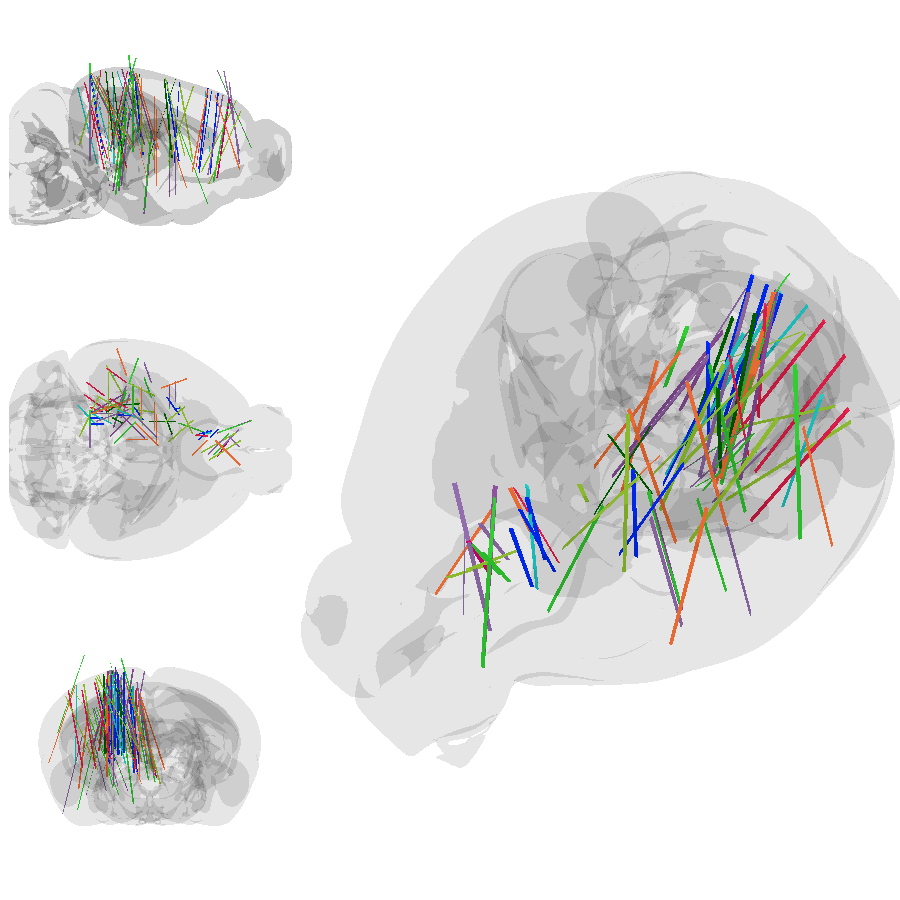

In [47]:
from PIL import Image

grid_image = Image.new('RGBA', (900, 900))

grid_image.paste(s_png, (0, 0))
grid_image.paste(h_png, (0, 300))
grid_image.paste(c_png, (0, 600))
grid_image.paste(angled_png, (300, 0))

grid_image